In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [161]:
data = pd.read_csv('sales-data.csv', header=None)
data.columns=['Month','Sales']
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')

In [162]:
data[0:2]

,Sales
Month,
1980-01-01,154
1980-02-01,96


In [163]:
data.isnull().any()

Sales    False
dtype: bool

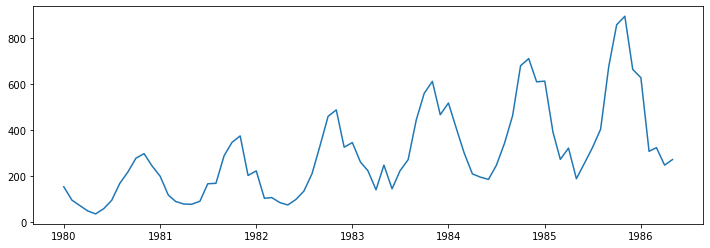

In [164]:
# Checking Stationarity of the data
plt.figure(figsize=(12,4))
plt.plot(data)
plt.show()

Data has growing trend so the data is not stationary by visualising

In [165]:
data.head()

,Sales
Month,
1980-01-01,154
1980-02-01,96
1980-03-01,73
1980-04-01,49
1980-05-01,36


In [166]:
# Train Test Split
train_len = 60
train = data[:train_len]
test = data[train_len:]

In [167]:
train.shape

(60, 1)

In [168]:
# Test the stationarity - ADF
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data)
adf_test

(0.5819064761511071,
 0.987161059552855,
 12,
 64,
 {'1%': -3.53692771987915,
  '5%': -2.907887369384766,
  '10%': -2.591493291015625},
 703.2231100041784)

ADF Statistics is greater than Critical Values(@5%: 2.907887369384766) and P-value is greater than than significant value so the data is not stationary

In [169]:
# Test the stationarity - KPSS
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data)
kpss_test

C:\Users\z0038b4f\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


(0.6576276787394588,
 0.017397483750958287,
 12,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Again here KPSS Statiscs is greather than than critical values and p-value is less than significat threshold 0.05, so data is not stationary

In [170]:
# Doing boxcox transformation for making data to constant variance
from scipy.stats import boxcox

# Boxcox Transformation

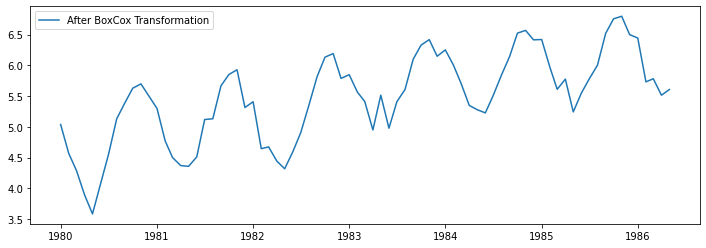

In [171]:
# tranforming the data
data_boxcox = pd.Series(boxcox(data['Sales'], lmbda=0), index=data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After BoxCox Transformation')
plt.legend(loc = 'best')
plt.show()

In [172]:
data_boxcox.head()

Month
1980-01-01    5.036953
1980-02-01    4.564348
1980-03-01    4.290459
1980-04-01    3.891820
1980-05-01    3.583519
dtype: float64

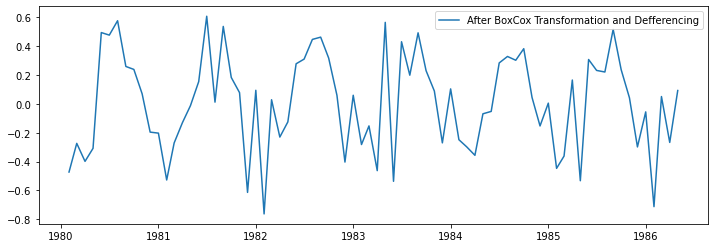

In [173]:
# Defferencing
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift())
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After BoxCox Transformation and Defferencing')
plt.legend(loc = 'best')
plt.show()

In [174]:
data_boxcox_diff.head()

Month
1980-02-01   -0.472604
1980-03-01   -0.273889
1980-04-01   -0.398639
1980-05-01   -0.308301
1980-06-01    0.494019
dtype: float64

In [175]:
# ADF Test again
adf_test = adfuller(data_boxcox_diff)
adf_test

(-8.348568396775017,
 3.038101361627475e-13,
 7,
 68,
 {'1%': -3.530398990560757,
  '5%': -2.9050874099328317,
  '10%': -2.5900010121107266},
 -24.375339218045454)

In [176]:
# KPSS Test again
kpss_test = kpss(data_boxcox_diff)
kpss_test

C:\Users\z0038b4f\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.22524710869484132,
 0.1,
 12,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Data is stataionary now

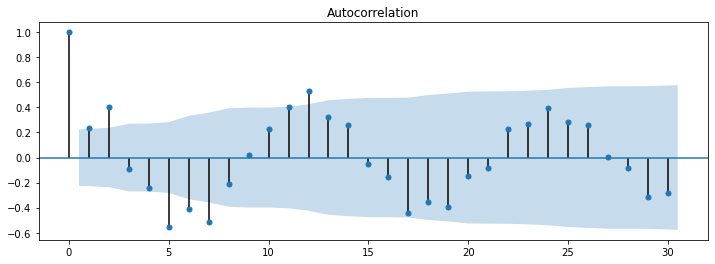

In [177]:
# Plotting Autocorrelation Function(ACF)
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(),lags=30)
plt.show()

C:\Users\z0038b4f\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


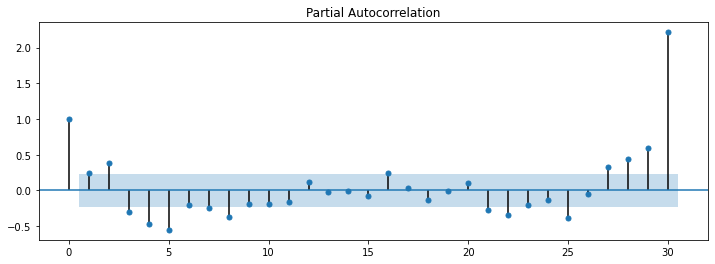

In [178]:
# Importing required library
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags=30)
plt.show()

## Train Test Split

In [179]:
# Use the first 60 rows as train data
train_data_boxcox = data_boxcox[0:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [180]:
train_data_boxcox.shape

(60,)

## Building ARMA model

In [181]:
# importting required library
from statsmodels.tsa.arima_model import ARIMA

In [182]:
model = ARIMA(train_data_boxcox_diff, order = (4,0,3))
model_fit = model.fit()
model_fit.params

C:\Users\z0038b4f\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const      0.019244
ar.L1.y    0.257272
ar.L2.y    1.092253
ar.L3.y   -0.641709
ar.L4.y   -0.480929
ma.L1.y   -0.807334
ma.L2.y   -0.764253
ma.L3.y    0.977573
dtype: float64

In [183]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

In [184]:
y_hat_arma.head()

Month
1980-02-01 00:00:00   -0.472604
1980-03-01 00:00:00   -0.273889
1980-04-01 00:00:00   -0.398639
1980-05-01 00:00:00   -0.308301
1980-06-01 00:00:00    0.494019
dtype: object

In [185]:
train['Sales'].head()

Month
1980-01-01    154
1980-02-01     96
1980-03-01     73
1980-04-01     49
1980-05-01     36
Name: Sales, dtype: int64

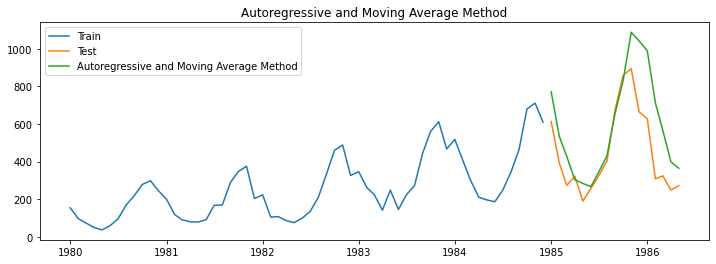

In [205]:
# Plot Train, Test and Forecast
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='Autoregressive and Moving Average Method')
plt.legend(loc='best')
plt.title('Autoregressive and Moving Average Method')
plt.show()

In [206]:
# RMSE and MAPE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Sales'],y_hat_arma['arma_forecast'][test.index.min():])).round(2)
mape = round(np.mean(np.abs(test['Sales']-y_hat_arma['arma_forecast'][test.index.min():])/test['Sales'])*100,2)

In [207]:
print(rmse, mape)

194.81 37.31


# ARIMA(4, 1, 3)

In [208]:
from statsmodels.tsa.arima_model import ARIMA

In [209]:
model = ARIMA(train_data_boxcox, order=(4,1,3))
model_fit = model.fit()
print(model_fit.params)

C:\Users\z0038b4f\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\z0038b4f\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const        0.019244
ar.L1.D.y    0.257272
ar.L2.D.y    1.092253
ar.L3.D.y   -0.641709
ar.L4.D.y   -0.480929
ma.L1.D.y   -0.807334
ma.L2.D.y   -0.764253
ma.L3.D.y    0.977573
dtype: float64


In [213]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox_diff'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

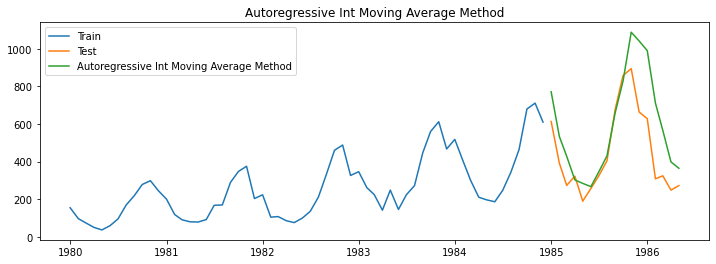

In [214]:
# Plot Train, Test and Forecast
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='Autoregressive Int Moving Average Method')
plt.legend(loc='best')
plt.title('Autoregressive Int Moving Average Method')
plt.show()

In [215]:
# RMSE and MAPE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Sales'],y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = round(np.mean(np.abs(test['Sales']-y_hat_arima['arima_forecast'][test.index.min():])/test['Sales'])*100,2)

In [216]:
print(rmse, mape)

194.81 37.31


# SARIMA(7, 2, 9)(3, 1, 1) and seasonality=12

In [192]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [236]:
model = SARIMAX(train_data_boxcox, order=(7,2,9), seasonal_order=(3,1,1,12))
model_fit = model.fit()
print(model_fit.params)

C:\Users\z0038b4f\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\z0038b4f\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\z0038b4f\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\z0038b4f\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\z0038b4f\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:994: UserWarning: Non-s

ar.L1      -1.213725
ar.L2      -0.694168
ar.L3      -0.086800
ar.L4      -0.119378
ar.L5      -0.551290
ar.L6      -0.696552
ar.L7      -0.369499
ma.L1      -0.261750
ma.L2      -0.501560
ma.L3      -0.314394
ma.L4       0.338198
ma.L5       0.184836
ma.L6      -0.262308
ma.L7      -0.625165
ma.L8      -0.224118
ma.L9       0.685235
ar.S.L12   -0.417099
ar.S.L24   -0.260378
ar.S.L36   -0.667199
ma.S.L12   -0.263471
sigma2      0.017202
dtype: float64


In [237]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(),data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

In [238]:
# RMSE and MAPE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Sales'],y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = round(np.mean(np.abs(test['Sales']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Sales'])*100,2)

In [239]:
print(rmse,mape)

49.76 13.1
